In [ ]:
# preliminary-analysis-2024-comb-building.ipynb
#
# Bryan Daniels
# 2024/3/29
#
# Continuing analysis started in 2021, looking for predictors of comb-building
# and thinking about ways the dynamics of the total amount of comb-building 
# could be modeled
#

In [711]:
import pandas as pd
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt
%matplotlib inline
from toolbox import defaultFigure
defaultFigure.setDefaultParams()
from toolbox import gifsicle
from importlib import reload  
import datetime as dt
import random
import cProfile

In [2]:
# import stuff from jacob davidson's github repository: https://github.com/jacobdavidson/bees_drones_2019data
from bees_drones_2019data import displayfunctions as bp  # 'bee plots'
from bees_drones_2019data import datafunctions as dfunc
from bees_drones_2019data import definitions_2019 as bd
dfunc.init(bd) 
bp.init(bd)
bd.year

2019

# Load data

The days with festoons are roughly (1) between day 4 and 20 and (2) between day 46 and 65

In [753]:
days_to_load = np.arange(0,10)

## Load 5-minute behavioral data

(Note that these data are in a different format than what was loaded in `preliminary-analysis-2021-comb-building.ipynb`)

In [754]:
# data from 2019: https://zenodo.org/records/7298798
behavioral_data_dir = '../Data/240329/df_day5min/'

In [755]:
dfList = [ pd.read_hdf('{}df_day5min_{:03d}.hdf'.format(behavioral_data_dir,daynum)) for daynum in days_to_load ]
dfFiveMinute = pd.concat(dfList)

In [756]:
# time conversion
minutes_per_division = 5
divisions_per_day = int(24*60/minutes_per_division)
dfFiveMinute['Time (days)'] = dfFiveMinute['Day number'] + dfFiveMinute['timedivision']/divisions_per_day

## Load trajectory data

In [7]:
# data from 2019: https://zenodo.org/records/7298798
trajectory_data_dir = '../Data/231018/trajectories_000-019/'

In [8]:
#dfTrajList = [ pd.read_hdf('{}beetrajectories_{:03d}.hdf'.format(trajectory_data_dir,daynum)) for daynum in days_to_load ]
#dfTraj = pd.concat(dfTrajList) # avoid explicitly creating list to save memory
filenames = [ '{}beetrajectories_{:03d}.hdf'.format(trajectory_data_dir,daynum) for daynum in days_to_load ]
dfTraj = pd.concat(map(pd.read_hdf,filenames))

In [9]:
# time conversion
frames_per_second = 3
frames_per_day = 24*60*60*frames_per_second
dfTraj['Time (days)'] = dfTraj['daynum'] + dfTraj['framenum']/frames_per_day

In [331]:
dfTraj['framenum'].apply(lambda framenum: framenum)

0                 0
1                 6
2                 7
3                 8
4                 9
              ...  
113900778    259180
113900779    259181
113900780    259182
113900781    259183
113900782    259184
Name: framenum, Length: 113900783, dtype: int64

In [318]:
dfTraj.head()

,daynum,framenum,uid,x,y,camera,theta,Time (days)
0,4,0,4,576,4770,0,2.84584,4.000000
1,4,6,4,563,4762,0,-3.06435,4.000023
2,4,7,4,563,4762,0,-3.11650,4.000027
3,4,8,4,557,4762,0,-2.96840,4.000031
4,4,9,4,557,4757,0,-2.99306,4.000035


In [319]:
print("Trajectories use {:.1f} GB of memory.".format(dfTraj.memory_usage().sum()/1e9))

Trajectories use 8.2 GB of memory.


## Load comb contents data

In [291]:
# data from 2019: https://zenodo.org/records/7298798
comb_contents_dir = '../Data/240329/comb-contents-images2019/'

In [292]:
# load the comb structure
combDict = dict([ (daynum, pickle.load(gzip.open(comb_contents_dir+'comb_{:03d}.pklz'.format(daynum),'rb'))) for daynum in days_to_load ])

In [293]:
combDict[4]

# Find bees that are festooning a lot or a little, and compare their trajectories

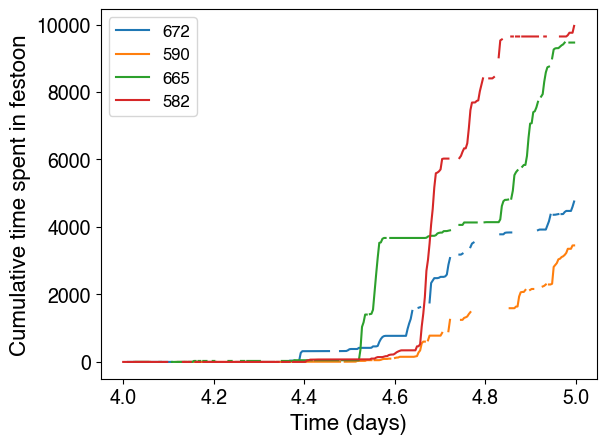

In [15]:
# sanity check: recreating a plot from preliminary-analysis-2021-comb-building.ipynb
# (largest festooners)
for beeID in [672,590,665,582]:
    dfFiveMinuteBee = dfFiveMinute[dfFiveMinute['Bee unique ID']==beeID]
    times = dfFiveMinuteBee['Time (days)']
    cumulativeFestoon = np.cumsum(dfFiveMinuteBee['Festoon'])
    plt.plot(times,cumulativeFestoon,label=beeID)
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Cumulative time spent in festoon');

In [18]:
dfFiveMinute.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'Mean x-shifted', 'Mean y', 'Bee unique ID', 'Cohort ID',
       'Num. outside trips', 'Num. dance floor visits',
       'Dispersion-minute avg.', 'Frame 0 - Num. crossings',
       'Frame 1 - Num. crossings', 'Frame 2 - Num. crossings',
       'Frame 3 - Num. crossings', 'Frame 4 - Num. crossings',
       'Frame 5 - Num. crossings', 'timedivision', 'Time (days)'],
      dtype='object')

In [728]:
def plot_bees_at_time(dfTraj,daynum,framenum,ax=[],show_comb=True,show_frame=False,color='crimson'):

    if show_comb: # quite slow compared to showframe
        ax = bp.showcomb(combDict[daynum],ax=ax)
    if show_frame:
        ax = bp.showframe(ax=ax)
    #plt.figure()
    #ax = plt.gca()
    dfTraj_one_frame = dfTraj[(dfTraj['daynum']==daynum) & (dfTraj['framenum']==framenum)]
    #print(dfTraj_one_frame)
    # for beeid in dfTraj_one_frame['uid'].unique():
    #     dfTraj_one_frame_one_bee = dfTraj_one_frame[dfTraj_one_frame['uid']==beeid]
    #     bp.plotbee_xy(dfTraj_one_frame_one_bee['x'],dfTraj_one_frame_one_bee['y'],dfTraj_one_frame_one_bee['camera'],
    #                   ax=ax,color='white',s=100,joined=False)
    return bp.plotbee_xy(dfTraj_one_frame['x'],dfTraj_one_frame['y'],dfTraj_one_frame['camera'],
                      ax=ax,color=color,s=100,joined=False)

In [827]:
def plot_history(dfTraj,beeid,start_time,delta_t,ax=[],show_comb=True,show_frame=False,joined=True,color='crimson',
                 show_id=False,maxxydiff=80):
    """
    Visualize a bee's history relative to a given start time
    
    See history_trajectory

    show_id (False)          : Display bee's id near its history trajectory (currently doesn't take into account 
                               camera data, so just uses vertical "y" data
    """
    if show_comb: # quite slow compared to showframe
        ax = bp.showcomb(combDict[daynum],ax=ax)
    if show_frame:
        ax = bp.showframe(ax=ax)
    
    history = history_trajectory(dfTraj, beeid, start_time, delta_t)

    ax = bp.plotbee_xy(history['x'],history['y'],history['camera'],
                      ax=ax,color=color,joined=joined,maxxydiff=maxxydiff)

    if show_id:
        ax.text(0,np.mean(history['y']),beeid)
    
    return ax

In [772]:
# make animated gif of bee motion
daynum = 4
bee_subset = None #[665] #[582]
show_comb = False #True
show_frame = True #False
min_day_frac,max_day_frac = 0.6,0.65 #0.,0.5
min_framenum,max_framenum = int(min_day_frac*frames_per_day),int(max_day_frac*frames_per_day)
frame_step = 5 # number of frames to skip between renderings
framenums = range(min_framenum,max_framenum,frame_step)
print("Plotting day {}, frames {} (hour {}) to {} (hour {}) ({} frames)...".format(
    daynum,min_framenum,min_framenum/frames_per_day*24,max_framenum,max_framenum/frames_per_day*24,len(framenums)))
dfTraj_cut = dfTraj[(dfTraj['daynum']==daynum) & (min_framenum < dfTraj['framenum']) & (dfTraj['framenum'] < max_framenum)]
if bee_subset:
    dfTraj_cut = dfTraj_cut[dfTraj_cut['uid'].isin(bee_subset)]
plot_func = lambda framenum: plot_bees_at_time(dfTraj_cut,daynum,framenum,show_comb=show_comb,show_frame=show_frame)

gifsicle.gifsiclePlot(plot_func,
                          framenums,
                          '240418_bee_trajectories_day_{}_frame_{}_to_{}.gif'.format(daynum,min_framenum,max_framenum),
                          delay=1,
                          annotateList=[framenum_to_datetime(daynum,frame).strftime('%c') for frame in framenums])
plt.close('all')

Plotting day 4, frames 155520 (hour 14.399999999999999) to 168480 (hour 15.600000000000001) (2592 frames)...


100%|███████████████████████████████████████| 2592/2592 [05:33<00:00,  7.78it/s]
gifsicle: warning: too many colors, using local colormaps
  (You may want to try ‘--colors 256’.)


gifsicleAnnotate: GIF animation written to 240419_bee_trajectories_day_4_frame_155520_to_168480.gif


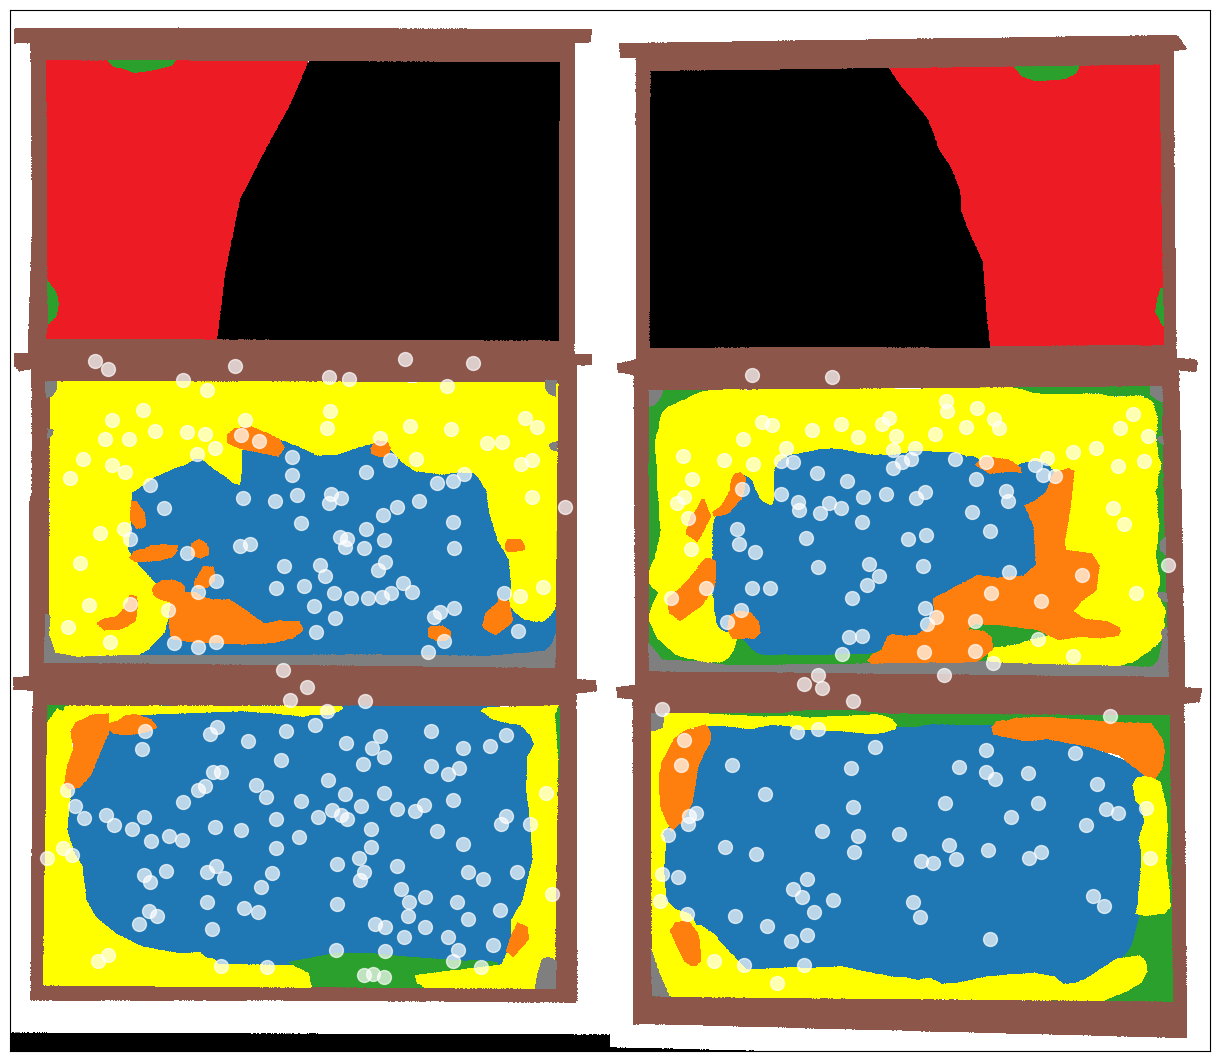

In [35]:
plot_bees_at_time(dfTraj,4,10)

<Axes: >

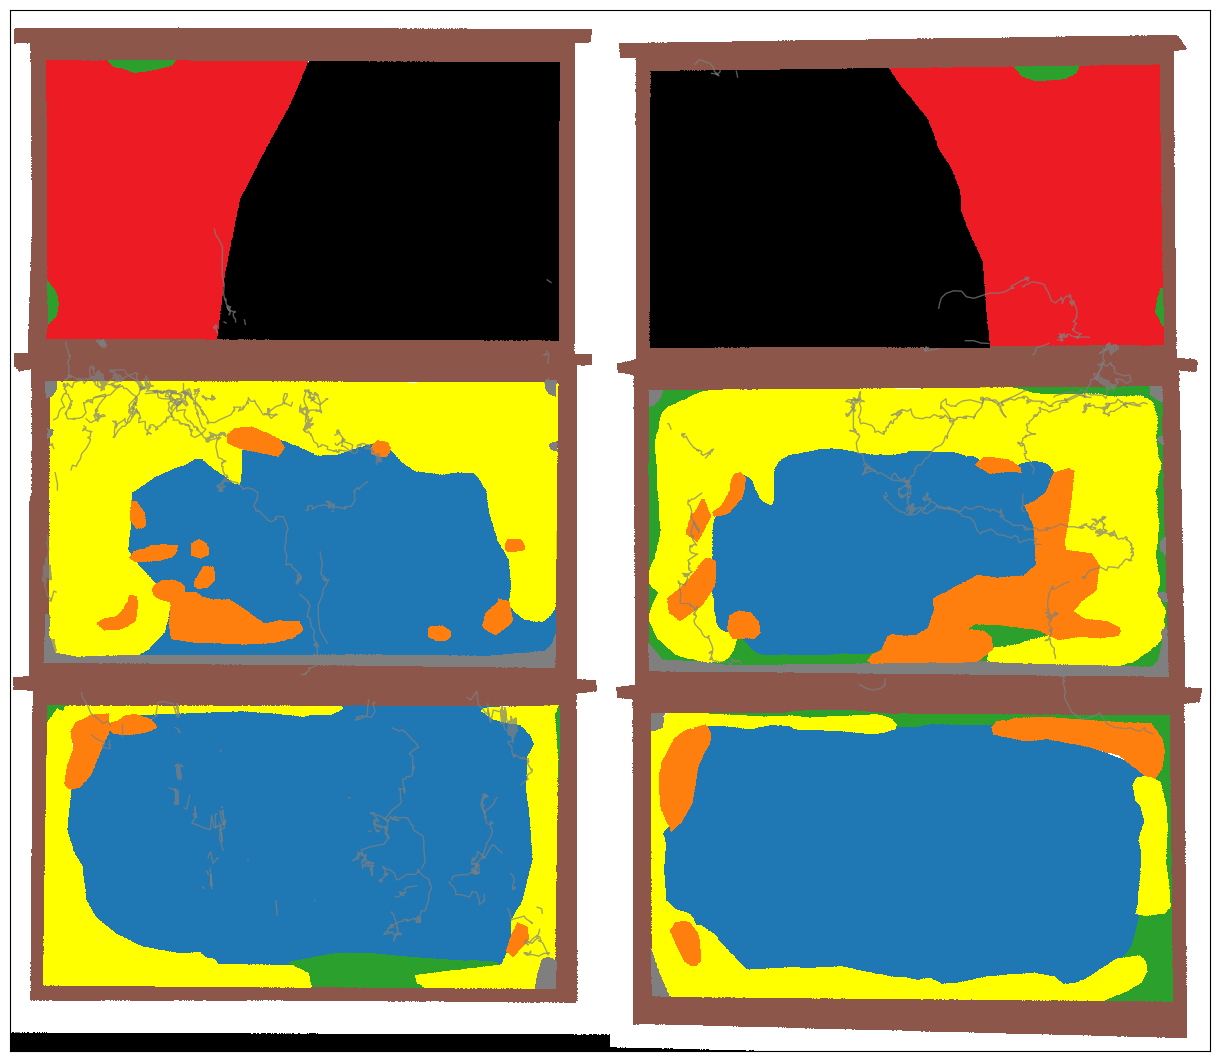

In [27]:
# plot trajectory of a single bee
beeID = 672 #582
minTime,maxTime = 4.3,4.4 # days
dfTraj_selected = dfTraj[(dfTraj['uid']==beeID) & (minTime < dfTraj['Time (days)']) & (dfTraj['Time (days)'] < maxTime)]

daynum = int(np.floor(minTime))
ax = bp.showcomb(combDict[daynum])
bp.plotbee_xy(dfTraj_selected['x'],dfTraj_selected['y'],dfTraj_selected['camera'],ax=ax,color='gray')
#bp.showframe(ax)

# what are statistics of in-festoon/out-of-festoon dynamics for individual bees?

In [ ]:
# odd: on day 4, one bee (bee 1522) shows up in the data often but with all NaNs

In [88]:
def bouts_from_time_series(series):
    """
    Takes pandas series indexed by time and returns dataframe with information about consecutive bouts
    over which behavior was constant.
    """
    # each element of bouts_list is a chunk of the original series over which behavior is constant
    bouts_list = np.split(series,np.where(np.diff(series)!=0)[0]+1)

    bouts_data = []
    for bout in bouts_list:
        bouts_data.append([bout.iloc[0],len(bout),bout.index[0],bout.index[-1]])

    return pd.DataFrame(bouts_data,columns=['Bout state','Bout length in time divisions','Bout start','Bout end'])

In [329]:
def framenum_to_datetime(daynum,framenum):
    return bd.alldaytimestamps[daynum] + dt.timedelta(seconds=framenum/frames_per_second)

In [350]:
def seconds_past_midnight(datetime):
    return (datetime - datetime.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

In [353]:
def datetime_to_framenum(datetime,frames_per_second=frames_per_second):
    return int(np.floor(seconds_past_midnight(datetime)*frames_per_second))

In [215]:
def timediv_to_datetime(daynum,timediv,divisions_per_day):
    assert(timediv < divisions_per_day)
    return bd.alldaytimestamps[daynum] + dt.timedelta(days=timediv/divisions_per_day)

In [384]:
def datetime_to_daynum(datetime):
    date_list = [str(ts.date()) for ts in bd.alldaytimestamps]
    return date_list.index(str(datetime.date()))

In [306]:
# get_onsubstrate appears to be the equivalent of get_inout_estimates but for a particular substrate
# (the default substrate is "Festoon", which is what we want here)
# day_uids = list of bee ids (len # bees)
# day_ages = list of bee ages (len # bees)
# all_ontop = array of inferred binary status of bees vs. time: on the substrate or not (shape #bees x #times)
# bee_obs = number of observations of each bee in each time window (shape #bees x #times)
# bee_data = all relevant data in a 3D array (?) (shape #bees x #times x #statistics)
df_festoon_list = []
for daynum in dfFiveMinute['Day number'].unique():
    # (Note: get_onsubstrate seems to be currently limited to one day at a time)
    dfFiveMinute_day = dfFiveMinute[dfFiveMinute['Day number']==daynum]
    day_uids, day_ages, all_ontop, bee_obs, bee_data = dfunc.get_onsubstrate(dfFiveMinute_day)
    
    # construct binary dataframe for "in festoon" versus time for each bee
    df_festoon_list.append( pd.DataFrame(all_ontop,
                    columns=[ timediv_to_datetime(int(daynum),timediv,divisions_per_day) for timediv in range(int(divisions_per_day))],
                    index=[ "Bee {}".format(uid) for uid in day_uids ]) )

df_festoon = pd.concat(df_festoon_list,axis=1)

# construct dataframe of festoon/non-festoon bouts for each bee 
bee_bouts_list = []
for beeid in df_festoon.index:
    bee_bouts = bouts_from_time_series(df_festoon.loc[beeid]).dropna()
    bee_bouts['Bee id'] = int(beeid.removeprefix('Bee '))
    bee_bouts['Bee start time'] = min(bee_bouts['Bout start'])
    bee_bouts['Bee final time'] = max(bee_bouts['Bout end'])
    bee_bouts_list.append(bee_bouts)
df_festoon_bouts = pd.concat(bee_bouts_list).set_index('Bee id')

# include time conversion
df_festoon_bouts['Bout length in minutes'] = df_festoon_bouts['Bout length in time divisions']*minutes_per_division
#df_festoon_bouts['Bout start minute'] = df_festoon_bouts['Bout start'].apply(lambda s: int(s.removeprefix('Minute ')))
#df_festoon_bouts['Bout end minute'] = df_festoon_bouts['Bout end'].apply(lambda s: int(s.removeprefix('Minute ')))

/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/bdaniel6/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/bdaniel6/opt/

In [307]:
df_festoon_bouts

,Bout state,Bout length in time divisions,Bout start,Bout end,Bee start time,Bee final time,Bout length in minutes
Bee id,,,,,,,
4,0.0,214,2019-06-09 00:00:00,2019-06-09 17:45:00,2019-06-09,2019-06-10 23:55:00,1070
4,1.0,25,2019-06-09 17:50:00,2019-06-09 19:50:00,2019-06-09,2019-06-10 23:55:00,125
4,0.0,4,2019-06-09 19:55:00,2019-06-09 20:10:00,2019-06-09,2019-06-10 23:55:00,20
4,1.0,5,2019-06-09 20:15:00,2019-06-09 20:35:00,2019-06-09,2019-06-10 23:55:00,25
4,0.0,31,2019-06-09 20:40:00,2019-06-09 23:10:00,2019-06-09,2019-06-10 23:55:00,155
...,...,...,...,...,...,...,...
2620,0.0,864,2019-06-12 00:00:00,2019-06-14 23:55:00,2019-06-12,2019-06-14 23:55:00,4320
2621,0.0,864,2019-06-12 00:00:00,2019-06-14 23:55:00,2019-06-12,2019-06-14 23:55:00,4320
2622,0.0,576,2019-06-12 00:00:00,2019-06-13 23:55:00,2019-06-12,2019-06-13 23:55:00,2880


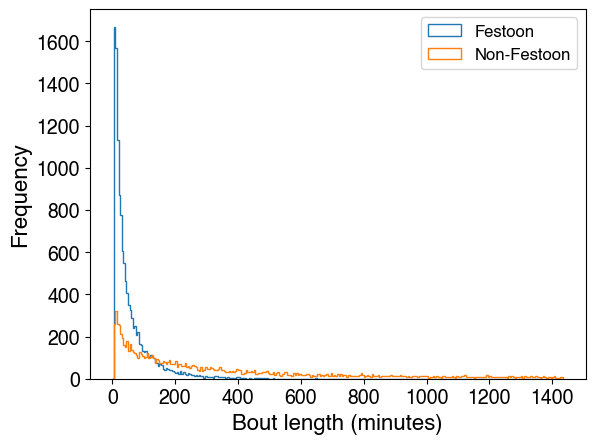

In [308]:
# exclude the bouts that start at first possible time or end at last possible time
df_non_cut_bouts = df_festoon_bouts[ 
    (df_festoon_bouts['Bout start']!=df_festoon_bouts['Bee start time']) & (df_festoon_bouts['Bout end']!=df_festoon_bouts['Bee final time'])]

# plot histograms of lengths of festoon and non-festoon bouts
bins = minutes_per_division*np.arange(divisions_per_day)
df_non_cut_bouts[df_non_cut_bouts['Bout state']==1]['Bout length in minutes'].plot.hist(bins=bins,
                                                                                        label='Festoon',
                                                                                        histtype='step')
df_non_cut_bouts[df_non_cut_bouts['Bout state']==0]['Bout length in minutes'].plot.hist(bins=bins,
                                                                                        label='Non-Festoon',
                                                                                        histtype='step')
plt.xlabel('Bout length (minutes)')
plt.legend()

In [309]:
df_non_cut_bouts

,Bout state,Bout length in time divisions,Bout start,Bout end,Bee start time,Bee final time,Bout length in minutes
Bee id,,,,,,,
4,1.0,25,2019-06-09 17:50:00,2019-06-09 19:50:00,2019-06-09,2019-06-10 23:55:00,125
4,0.0,4,2019-06-09 19:55:00,2019-06-09 20:10:00,2019-06-09,2019-06-10 23:55:00,20
4,1.0,5,2019-06-09 20:15:00,2019-06-09 20:35:00,2019-06-09,2019-06-10 23:55:00,25
4,0.0,31,2019-06-09 20:40:00,2019-06-09 23:10:00,2019-06-09,2019-06-10 23:55:00,155
4,1.0,1,2019-06-09 23:15:00,2019-06-09 23:15:00,2019-06-09,2019-06-10 23:55:00,5
...,...,...,...,...,...,...,...
2612,0.0,4,2019-06-14 09:05:00,2019-06-14 09:20:00,2019-06-12,2019-06-14 23:55:00,20
2612,1.0,65,2019-06-14 09:25:00,2019-06-14 14:45:00,2019-06-12,2019-06-14 23:55:00,325
2612,0.0,17,2019-06-14 14:50:00,2019-06-14 16:10:00,2019-06-12,2019-06-14 23:55:00,85


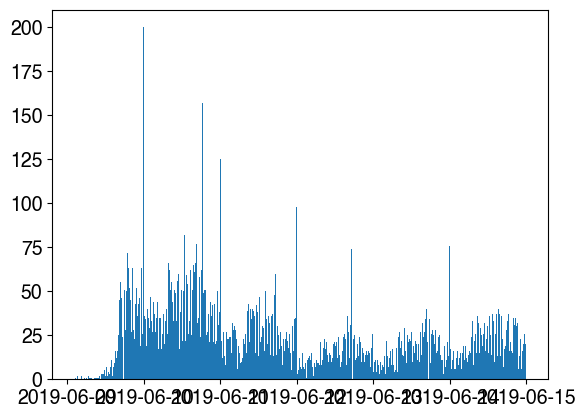

In [310]:
plt.hist(df_non_cut_bouts['Bout end'],bins=1000);

In [297]:
df_non_cut_bouts[(df_non_cut_bouts['Bout state']==1) & (df_non_cut_bouts['Bout length in minutes']>400)]

,Bout state,Bout length in time divisions,Bout start,Bout end,Bee start time,Bee final time,Bout length in minutes
Bee id,,,,,,,
240,1.0,92,2019-06-10 10:35:00,2019-06-10 18:10:00,2019-06-09,2019-06-10 23:55:00,460
425,1.0,91,2019-06-10 10:40:00,2019-06-10 18:10:00,2019-06-09,2019-06-10 23:55:00,455
582,1.0,101,2019-06-10 07:45:00,2019-06-10 16:05:00,2019-06-09,2019-06-10 23:55:00,505
584,1.0,83,2019-06-09 17:05:00,2019-06-09 23:55:00,2019-06-09,2019-06-10 23:55:00,415
593,1.0,84,2019-06-10 10:35:00,2019-06-10 17:30:00,2019-06-09,2019-06-10 23:55:00,420
623,1.0,83,2019-06-10 16:15:00,2019-06-10 23:05:00,2019-06-09,2019-06-10 23:55:00,415
657,1.0,129,2019-06-10 09:55:00,2019-06-10 20:35:00,2019-06-09,2019-06-10 23:55:00,645
684,1.0,129,2019-06-10 01:40:00,2019-06-10 12:20:00,2019-06-09,2019-06-10 23:55:00,645
715,1.0,91,2019-06-09 19:35:00,2019-06-10 03:05:00,2019-06-09,2019-06-10 23:55:00,455


<Axes: >

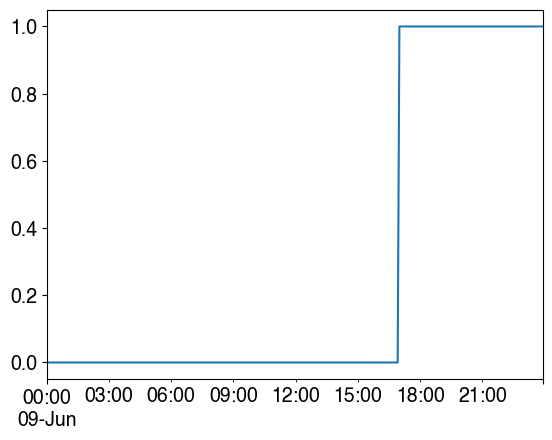

In [239]:
df_festoon.loc['Bee 1246'].plot()

In [240]:
df_festoon_bouts.loc[2070]

,Bout state,Bout length in time divisions,Bout start,Bout end,Bout length in minutes
Bee id,,,,,
2070,0.0,195,2019-06-09 00:00:00,2019-06-09 16:10:00,975
2070,1.0,90,2019-06-09 16:15:00,2019-06-09 23:40:00,450
2070,0.0,3,2019-06-09 23:45:00,2019-06-09 23:55:00,15


## do bees vary in their bout length distributions?

(array([589., 499., 193.,  89.,  31.,  18.,   5.,   6.,   5.,   4.]),
 array([   5.        ,  251.33333333,  497.66666667,  744.        ,
         990.33333333, 1236.66666667, 1483.        , 1729.33333333,
        1975.66666667, 2222.        , 2468.33333333]),
 <BarContainer object of 10 artists>)

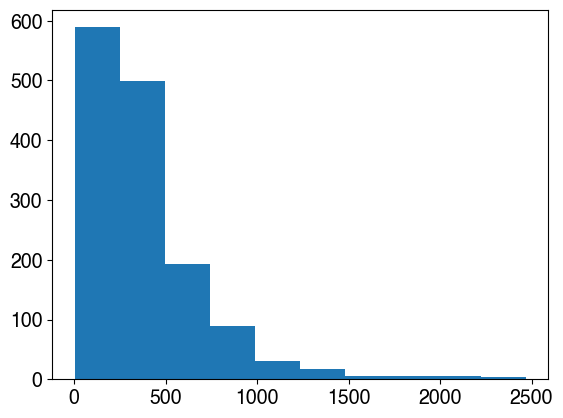

In [313]:
plt.hist(df_non_cut_bouts['Bout length in minutes'].groupby('Bee id').mean())

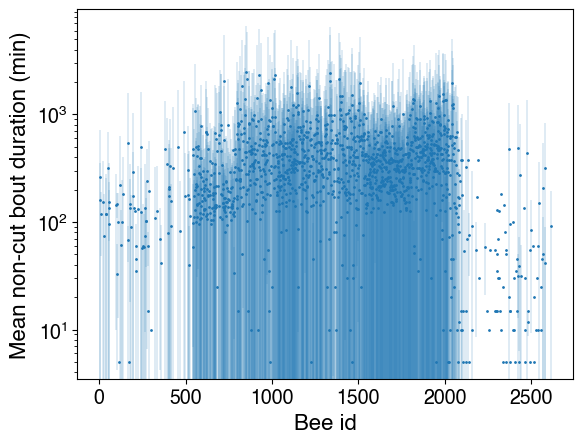

In [315]:
plt.errorbar(df_non_cut_bouts.index.unique(),
             df_non_cut_bouts['Bout length in minutes'].groupby('Bee id').mean(),
             yerr=df_non_cut_bouts['Bout length in minutes'].groupby('Bee id').std(),
             ls='',marker='o',ms=1,elinewidth=0.2)
plt.xlabel('Bee id')
plt.ylabel('Mean non-cut bout duration (min)')
plt.yscale('log')

Text(0, 0.5, 'Mean non-cut festoon duration (min)')

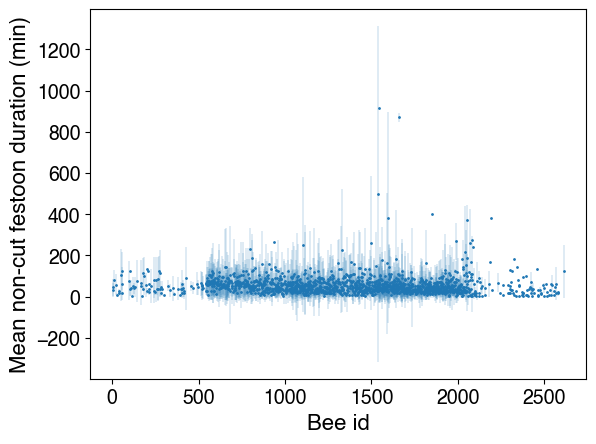

In [317]:
dff = df_non_cut_bouts[df_non_cut_bouts['Bout state']==1]
plt.errorbar(dff.index.unique(),
             dff['Bout length in minutes'].groupby('Bee id').mean(),
             yerr=dff['Bout length in minutes'].groupby('Bee id').std(),
             ls='',marker='o',ms=1,elinewidth=0.2)
plt.xlabel('Bee id')
plt.ylabel('Mean non-cut festoon duration (min)')
#plt.yscale('log')

# 2024/4/12 Find interaction events before festoon bouts

In [398]:
df_non_cut_bouts

,Bout state,Bout length in time divisions,Bout start,Bout end,Bee start time,Bee final time,Bout length in minutes
Bee id,,,,,,,
4,1.0,25,2019-06-09 17:50:00,2019-06-09 19:50:00,2019-06-09,2019-06-10 23:55:00,125
4,0.0,4,2019-06-09 19:55:00,2019-06-09 20:10:00,2019-06-09,2019-06-10 23:55:00,20
4,1.0,5,2019-06-09 20:15:00,2019-06-09 20:35:00,2019-06-09,2019-06-10 23:55:00,25
4,0.0,31,2019-06-09 20:40:00,2019-06-09 23:10:00,2019-06-09,2019-06-10 23:55:00,155
4,1.0,1,2019-06-09 23:15:00,2019-06-09 23:15:00,2019-06-09,2019-06-10 23:55:00,5
...,...,...,...,...,...,...,...
2612,0.0,4,2019-06-14 09:05:00,2019-06-14 09:20:00,2019-06-12,2019-06-14 23:55:00,20
2612,1.0,65,2019-06-14 09:25:00,2019-06-14 14:45:00,2019-06-12,2019-06-14 23:55:00,325
2612,0.0,17,2019-06-14 14:50:00,2019-06-14 16:10:00,2019-06-12,2019-06-14 23:55:00,85


Showing 2756 frames


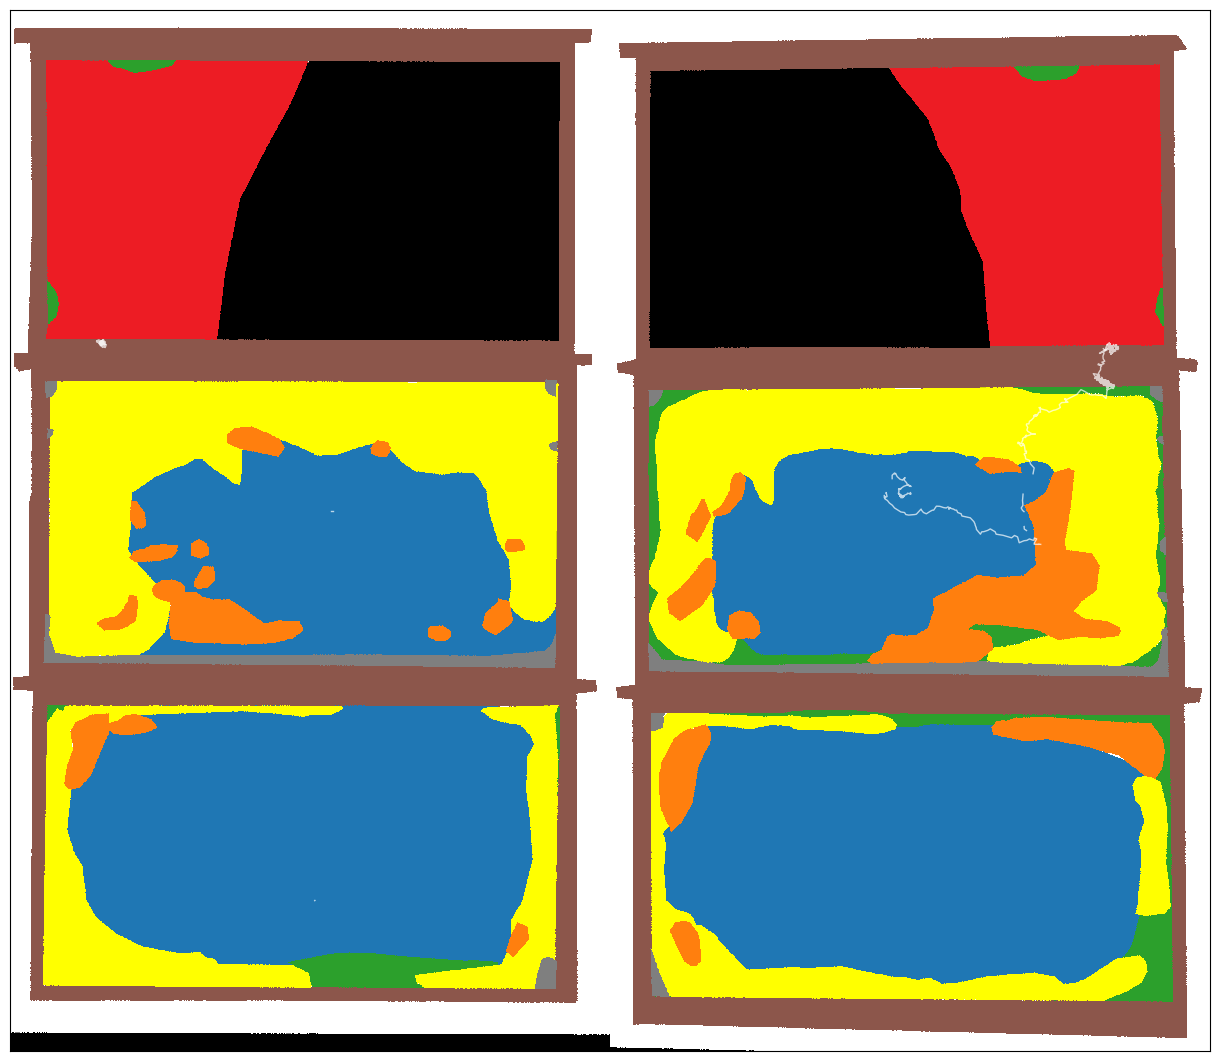

In [397]:
# plot trajectory of a single bee
beeID = 672 #672 #582
delta_t = 30 # minutes --- number of minutes to look at before the start of joining the festoon
# look at the first festoon bout for this bee
bout_start = df_non_cut_bouts.loc[beeID].iloc[0]['Bout start']
minTime = bout_start - dt.timedelta(minutes=delta_t)
maxTime = bout_start
minFrame = datetime_to_framenum(minTime)
maxFrame = datetime_to_framenum(maxTime)
dfTraj_selected_bee = dfTraj[(dfTraj['uid']==beeID)]
dfTraj_selected = dfTraj_selected_bee[(minFrame < dfTraj_selected_bee['framenum']) & (dfTraj_selected_bee['framenum'] < maxFrame)]
print("Showing {} frames".format(len(dfTraj_selected)))

if len(dfTraj_selected)>0:
    daynum = datetime_to_daynum(bout_start)
    ax = bp.showcomb(combDict[daynum])
    bp.plotbee_xy(dfTraj_selected['x'],dfTraj_selected['y'],dfTraj_selected['camera'],ax=ax,color='white')

In [ ]:
# to do: select trajectory data for all other bees in given time window and find interactions 

In [451]:
def interaction_events(dfTraj,beeID,minTime,maxTime,distance_thresh=10):
    """
    Returns dataFrame listing interaction events during which the bee with ID beeID is nearby another bee, within
    the time window between minTime and maxTime.  Here "nearby" means within a distance threshold and on the same 
    side of the hive.

    dfTraj                   : Trajectory dataframe containing framenumbers, (x,y) coordinates, and camera information.
    minTime                  : Minimum time to scan for interaction events, as a datetime object
    maxTime                  : Maximum time to scan for interaction events, as a datetime object
    distance_thresh (10)     : Distance in pixels within which two bees must be imaged in the same frame to count as an interaction
    """
    # select trajectory data from all bees from the desired time window
    minFrame = datetime_to_framenum(minTime)
    maxFrame = datetime_to_framenum(maxTime)
    dfTraj_selected = dfTraj[(minFrame < dfTraj['framenum']) & (dfTraj['framenum'] < maxFrame)]

    # select trajectory data from the selected bee
    dfTraj_selected_bee = dfTraj_selected[dfTraj_selected['uid']==beeID]
    
    # loop over time looking for interaction events
    interaction_data = []
    for frame in dfTraj_selected_bee['framenum'].unique():
        all_bee_frame_data = dfTraj_selected[dfTraj_selected['framenum']==frame]
        
        # get selected bee location for this time frame
        selected_bee_frame_data = all_bee_frame_data[all_bee_frame_data['uid']==beeID]
        beex = selected_bee_frame_data['x'].iloc[0],
        beey = selected_bee_frame_data['y'].iloc[0]
        beecamera = selected_bee_frame_data['camera'].iloc[0]

        # find distances from all other bees seen by the same camera (same side of hive) at this time frame
        all_bee_frame_data_same_side = all_bee_frame_data[all_bee_frame_data['camera']==beecamera]
        distances = pd.Series(np.linalg.norm([all_bee_frame_data_same_side['x']-beex,
                                              all_bee_frame_data_same_side['y']-beey],axis=0),
                              index=all_bee_frame_data_same_side['uid'])

        # append interaction data
        for other_bee in distances[distances < distance_thresh].index:
            if other_bee != beeID:
                other_bee_frame_data = all_bee_frame_data_same_side[all_bee_frame_data_same_side['uid']==other_bee]
                assert(len(other_bee_frame_data)==1) # should only have one timepoint for one bee in one frame
                interaction_data.append([frame,
                                         other_bee,
                                         other_bee_frame_data['x'].iloc[0],
                                         other_bee_frame_data['y'].iloc[0],
                                         other_bee_frame_data['camera'].iloc[0],
                                         distances[other_bee]])
    
    return pd.DataFrame(interaction_data,columns=['framenum','uid','x','y','camera','distance (pixels)'])

In [481]:
beeID = 672 #672 #582
delta_t = 30 # minutes --- number of minutes to look at before the start of joining the festoon
# look at the first festoon bout for this bee
bout_start = df_non_cut_bouts.loc[beeID].iloc[0]['Bout start']
minTime = bout_start - dt.timedelta(minutes=delta_t)
maxTime = bout_start

events = interaction_events(dfTraj,beeID,minTime,maxTime,distance_thresh=100)

In [482]:
# translate frame numbers to absolute time

# for now daynum has to be set manually based on which trajectory data is currently loaded...
daynum = 4
events['time'] = events['framenum'].apply(lambda f: framenum_to_datetime(daynum,f))

In [483]:
events

,framenum,uid,x,y,camera,distance (pixels),time
0,93601,1243,1597,2722,0,81.688432,2019-06-09 08:40:00.333333
1,93602,1243,1597,2724,0,89.403579,2019-06-09 08:40:00.666667
2,93602,1874,1613,2562,0,97.308787,2019-06-09 08:40:00.666667
3,93603,1243,1597,2730,0,90.271812,2019-06-09 08:40:01.000000
4,93603,1874,1613,2576,0,93.471921,2019-06-09 08:40:01.000000
...,...,...,...,...,...,...,...
521,98538,783,2639,1887,0,86.683332,2019-06-09 09:07:26.000000
522,98545,783,2638,1882,0,95.880134,2019-06-09 09:07:28.333333
523,98546,783,2638,1886,0,87.664132,2019-06-09 09:07:28.666667
524,98547,783,2635,1886,0,87.823687,2019-06-09 09:07:29.000000


In [465]:
bout_start

Timestamp('2019-06-09 09:10:00')

In [ ]:
# to do: would a pandas multiindex be faster for our purposes?  e.g. indexed by bee and framenum

# 2024/4/17 Compare recent interactions of festooning and non-festooning bees

In [502]:
print("A total of {} bees appear in the current loaded data.".format(len(dfFiveMinute['Bee unique ID'].unique())))

A total of 1931 bees appear in the current loaded data.


In [565]:
# construct dataframe with the first festoon bout for each bee
first_festoon_bouts = []
for beeid in df_non_cut_bouts.index.unique():
    if(type(df_non_cut_bouts.loc[beeid]) == pd.DataFrame):
        first_bout = df_non_cut_bouts.loc[beeid].iloc[0]
    else: # it's a Series because there's only one bout
        first_bout = df_non_cut_bouts.loc[beeid]
    assert(first_bout['Bout state']==1)
    first_festoon_bouts.append(first_bout)
df_first_festoon_bouts = pd.concat(first_festoon_bouts,axis=1).transpose()
df_first_festoon_bouts.index.name = 'Bee id'

## restrict to specified time window

In [797]:
minTimeDays = 4.6 #4.5  # start of time window in days
deltaTimeHours = 2 # duration of time window in hours

# time conversions
daynum = int(np.floor(minTimeDays))
dayStartTime = timediv_to_datetime(daynum,0,divisions_per_day)
minTime = dayStartTime + dt.timedelta(days=minTimeDays-daynum)
maxTime = minTime + dt.timedelta(hours=deltaTimeHours)
maxTimeDays = datetime_to_daynum(maxTime) + seconds_past_midnight(maxTime)/(24*60*60)
minTime_frame = datetime_to_framenum(minTime)
maxTime_frame = datetime_to_framenum(maxTime)

# calculate restricted dataframes
dfFiveMinute_windowed = dfFiveMinute[(dfFiveMinute['Time (days)'] > minTimeDays) & (dfFiveMinute['Time (days)'] < maxTimeDays)]
df_non_cut_bouts_windowed = df_non_cut_bouts[(df_non_cut_bouts['Bout start'] > minTime) & (df_non_cut_bouts['Bout start'] < maxTime)]
df_non_cut_bout_starts_windowed = df_non_cut_bouts_windowed[df_non_cut_bouts_windowed['Bout state']==1]
df_first_festoon_bouts_windowed = df_first_festoon_bouts[(df_first_festoon_bouts['Bout start'] > minTime) & \
                                                         (df_first_festoon_bouts['Bout start'] < maxTime) ]
dfTraj_windowed = dfTraj[(dfTraj['daynum']==daynum) & (dfTraj['framenum'] < maxTime_frame) & (dfTraj['framenum'] > minTime_frame)]

print("Restricting to time window starting at {} and ending at {}.".format(minTime,maxTime))
print()
print("In this time window, there are {} festoon bout start events.".format(len(df_non_cut_bout_starts_windowed)))
print("In this time window, there are {} first festoon bout start events.".format(len(df_first_festoon_bouts_windowed)))

Restricting to time window starting at 2019-06-09 14:24:00 and ending at 2019-06-09 16:24:00.

In this time window, there are 357 festoon bout start events.
In this time window, there are 293 first festoon bout start events.


In [571]:
df_first_festoon_bouts

,Bout state,Bout length in time divisions,Bout start,Bout end,Bee start time,Bee final time,Bout length in minutes
Bee id,,,,,,,
4,1.0,25,2019-06-09 17:50:00,2019-06-09 19:50:00,2019-06-09 00:00:00,2019-06-10 23:55:00,125
7,1.0,23,2019-06-09 15:30:00,2019-06-09 17:20:00,2019-06-09 00:00:00,2019-06-14 23:55:00,115
11,1.0,23,2019-06-09 15:30:00,2019-06-09 17:20:00,2019-06-09 00:00:00,2019-06-09 23:55:00,115
21,1.0,1,2019-06-09 09:40:00,2019-06-09 09:40:00,2019-06-09 00:00:00,2019-06-14 23:55:00,5
30,1.0,1,2019-06-09 16:10:00,2019-06-09 16:10:00,2019-06-09 00:00:00,2019-06-09 23:55:00,5
...,...,...,...,...,...,...,...
2565,1.0,5,2019-06-14 06:05:00,2019-06-14 06:25:00,2019-06-12 00:00:00,2019-06-14 23:55:00,25
2567,1.0,1,2019-06-14 15:05:00,2019-06-14 15:05:00,2019-06-12 00:00:00,2019-06-14 23:55:00,5
2578,1.0,4,2019-06-14 00:55:00,2019-06-14 01:10:00,2019-06-12 00:00:00,2019-06-14 23:55:00,20


## split into 5 age groups (not yet used)

In [ ]:
# as in preliminary-analysis-2021-comb-building.ipynb

In [491]:
bins = [0,5,7,13,15,30] #2 #[0,5,10,30]
cut = pd.cut(dfFiveMinute['Age'],bins) # cut into bins
#cut = pd.qcut(dfMinuteBees['Age'],bins) # cut into quantiles
dfFiveMinuteAgeBinned = dfFiveMinute.groupby(cut)

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_89447/779359619.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfFiveMinuteAgeBinned = dfFiveMinute.groupby(cut)


In [500]:
# number of bees in each age group
dfFiveMinuteAgeBinned['Bee unique ID'].unique().apply(len)

Age
(0, 5]      915
(5, 7]      775
(7, 13]     564
(13, 15]    519
(15, 30]    435
Name: Bee unique ID, dtype: int64

# Find interaction events in recent histories of new festooners and non-festooners

In [645]:
def interaction_partners(dfTraj,beeID,start_time,delta_t,distance_thresh,df_first_festoon_bouts,verbose=False):
    """
    Returns IDs of interaction partners of a given bee between start_time - delta_t and start_time, 
    and the subset of those that have festooned before the interaction.

    delta_t              : In minutes
    """

    minTime = start_time - dt.timedelta(minutes=delta_t)
    maxTime = start_time
    
    events = interaction_events(dfTraj,beeID,minTime,maxTime,distance_thresh=distance_thresh)

    # translate frame numbers to absolute time
    daynum = datetime_to_daynum(start_time)
    events['time'] = events['framenum'].apply(lambda f: framenum_to_datetime(daynum,f))

    # find interaction partners and find which of them started festooning before the interaction event
    other_bees = events['uid'].unique()
    other_bees_that_festoon = [ bee for bee in other_bees if bee in df_first_festoon_bouts.index ]
    other_bees_that_festoon_before = [ bee for bee in other_bees_that_festoon \
                                       if df_first_festoon_bouts.loc[bee]['Bout start'] < events[events['uid']==bee].iloc[0]['time'] ]

    if verbose:
        print("There are {} other bees that interact with bee {}.".format(len(other_bees),beeID))
        print("Of these, {} festoon at some point.".format(len(other_bees_that_festoon)))
        print("Of these, {} festooned before bee {} interacted with them.".format(len(other_bees_that_festoon_before),beeID))
        print()

    return other_bees,other_bees_that_festoon_before

In [877]:
delta_t = 2 #30 #60 #30 # minutes --- number of minutes to look at before the start of joining the festoon
distance_thresh = 100 #50 # pixels (80 pixels / cm)

# we will define "non-festoon" bees as those that have trajectory data but do not festoon until after
# the end of the window plus a buffer time > delta_t

buffer_time_hours = 2 # (hours after the end of the window to filter out soon-to-be-festooning bees)
assert(buffer_time_hours > delta_t/60)

bee_ids_windowed = dfFiveMinute_windowed['Bee unique ID'].unique()
bee_ids_windowed_nonfestoon = [ bee for bee in bee_ids_windowed \
                                if (bee not in df_first_festoon_bouts.index) \
                                or (df_first_festoon_bouts.loc[bee]['Bout start'] > maxTime + dt.timedelta(hours=buffer_time_hours)) ]

print("There are {} bees with data in the given time window.".format(len(bee_ids_windowed)))
print("Of these, {} are 'non-festoon' bees.".format(len(bee_ids_windowed_nonfestoon)))

# set random seed for choice of non-festooning bees
random.seed(12345)

interaction_data = []
interaction_data_nonfestoon = []
speed_data = []
speed_data_nonfestoon = []
for beeID in tqdm(df_first_festoon_bouts_windowed.index):

    # look at the first festoon bout for this bee
    bout_start = df_first_festoon_bouts_windowed.loc[beeID]['Bout start']

    # find and record numbers of interaction partners for the festooning bee
    partners,festoon_partners = interaction_partners(dfTraj,beeID,bout_start,delta_t,
                                                     distance_thresh,df_first_festoon_bouts)
    interaction_data.append([ beeID, len(partners), len(festoon_partners) ])

    # now for non-festooning bees:
    # we will create a dataset that has one non-festooning bee trajectory
    # matched to have the same bout_start time as each of the festooning bees
    
    # pick a random non-festooning bee
    nonfestoon_beeID = random.choice(bee_ids_windowed_nonfestoon)

    # find numbers of interaction partners for the non-festooning bee
    partners_nonfestoon,festoon_partners_nonfestoon = interaction_partners(dfTraj,nonfestoon_beeID,bout_start,delta_t,
                                                      distance_thresh,df_first_festoon_bouts)
    interaction_data_nonfestoon.append([ nonfestoon_beeID, len(partners_nonfestoon), len(festoon_partners_nonfestoon) ])

    # find speed data for festooning and non-festooning bee
    history = history_trajectory(dfTraj,beeID,bout_start,delta_t)
    history_nonfestoon = history_trajectory(dfTraj,nonfestoon_beeID,bout_start,delta_t)
    add_speed_data(history)
    add_speed_data(history_nonfestoon)
    speeds = history['speed (cm/s)']
    speeds_nonfestoon = history_nonfestoon['speed (cm/s)']
    speed_data.append([ beeID, np.mean(speeds), np.max(speeds) ])
    speed_data_nonfestoon.append([ nonfestoon_beeID, np.mean(speeds_nonfestoon), np.max(speeds_nonfestoon) ])
    

cols = ['bee ID','interaction partners','interaction partners previously in festoon']
df_interaction_data = pd.DataFrame(interaction_data,columns=cols)
df_interaction_data_nonfestoon = pd.DataFrame(interaction_data_nonfestoon,columns=cols)

speed_cols = ['bee ID','avg speed (cm/s)','max speed (cm/s)']
df_speed_data = pd.DataFrame(speed_data,columns=speed_cols)
df_speed_data_nonfestoon = pd.DataFrame(speed_data_nonfestoon,columns=speed_cols)

There are 1547 bees with data in the given time window.
Of these, 787 are 'non-festoon' bees.


100%|█████████████████████████████████████████| 293/293 [01:58<00:00,  2.47it/s]


Text(0.5, 0, 'Interaction partners previously in festoon')

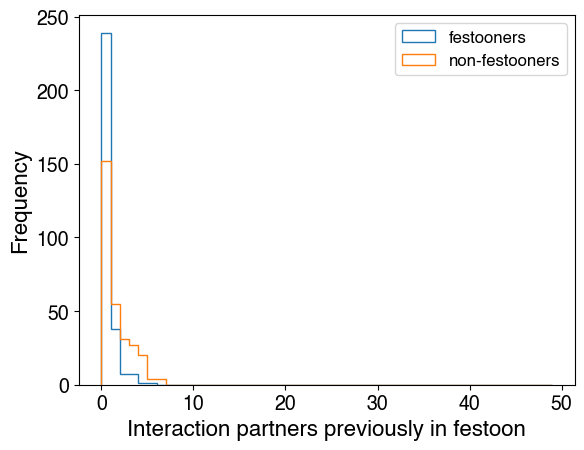

In [867]:
bins = range(50)
df_interaction_data['interaction partners previously in festoon'].plot.hist(bins=bins,histtype='step',
                                                                            label='festooners')
df_interaction_data_nonfestoon['interaction partners previously in festoon'].plot.hist(bins=bins,histtype='step',
                                                                                       label='non-festooners')
plt.legend()
plt.xlabel('Interaction partners previously in festoon')

Text(0.5, 0, 'Total interaction partners')

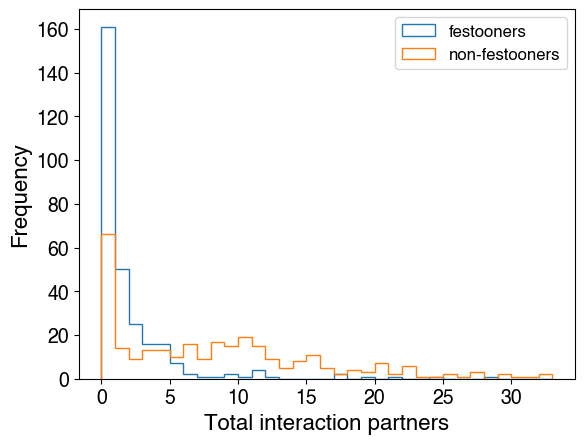

In [780]:
bins = range(0,max(df_interaction_data_nonfestoon['interaction partners']),1)
df_interaction_data['interaction partners'].plot.hist(bins=bins,histtype='step',label='festooners')
df_interaction_data_nonfestoon['interaction partners'].plot.hist(bins=bins,histtype='step',label='non-festooners')
plt.legend()
plt.xlabel('Total interaction partners')

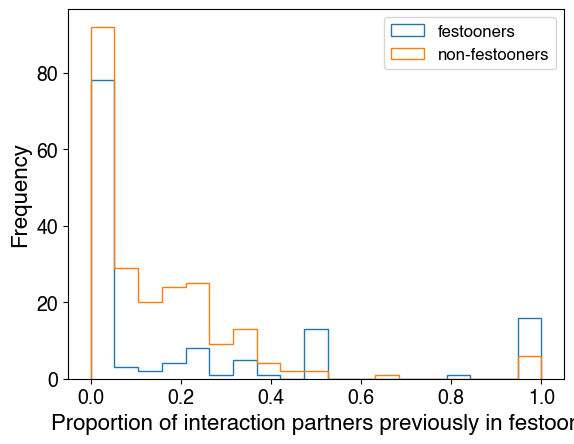

In [778]:
bins = np.linspace(0,1,20)
(df_interaction_data[
     'interaction partners previously in festoon']/df_interaction_data['interaction partners']).plot.hist(histtype='step',
                                                                                                          bins=bins,
                                                                                                          label='festooners')
(df_interaction_data_nonfestoon[
     'interaction partners previously in festoon']/df_interaction_data_nonfestoon['interaction partners']).plot.hist(histtype='step',
                                                                                                                     bins=bins,
                                                                                                                     label='non-festooners')
plt.xlabel('Proportion of interaction partners previously in festoon')
plt.legend()

Text(0.5, 0, 'Max speed (cm/s)')

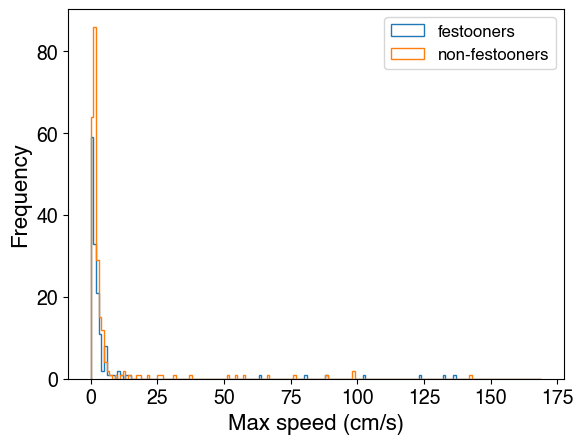

In [880]:
bins = range(0,int(np.ceil(max(df_speed_data['max speed (cm/s)']))),1)
df_speed_data['max speed (cm/s)'].plot.hist(bins=bins,histtype='step',label='festooners')
df_speed_data_nonfestoon['max speed (cm/s)'].plot.hist(bins=bins,histtype='step',label='non-festooners')
plt.legend()
plt.xlabel('Max speed (cm/s)')

Text(0.5, 0, 'Average speed (cm/s)')

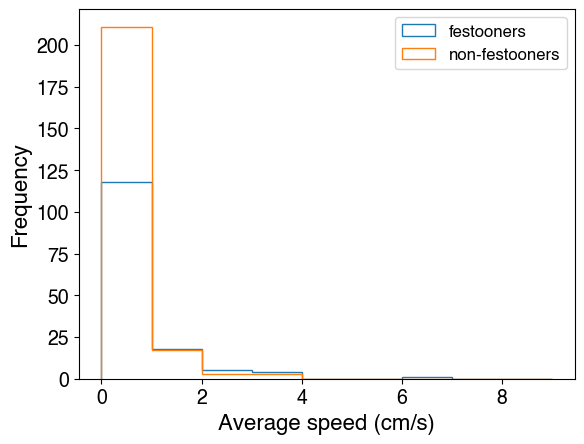

In [882]:
bins = range(0,10,1)
df_speed_data['avg speed (cm/s)'].plot.hist(bins=bins,histtype='step',label='festooners')
df_speed_data_nonfestoon['avg speed (cm/s)'].plot.hist(bins=bins,histtype='step',label='non-festooners')
plt.legend()
plt.xlabel('Average speed (cm/s)')

In [912]:
num_festooners_seen = df_speed_data.count()['avg speed (cm/s)']
total_festooners = df_speed_data.count()['bee ID']
print("Out of {} total festooners, {} were seen in the {} minute history, and {} were not.".format(
    total_festooners,num_festooners_seen,delta_t,total_festooners-num_festooners_seen))

num_nonfestooners_seen = df_speed_data_nonfestoon.count()['avg speed (cm/s)']
total_nonfestooners = df_speed_data_nonfestoon.count()['bee ID']
print("Out of {} total non-festooners, {} were seen in the {} minute history, and {} were not.".format(
    total_nonfestooners,num_nonfestooners_seen,delta_t,total_nonfestooners-num_nonfestooners_seen))

Out of 293 total festooners, 150 were seen in the 2 minute history, and 143 were not.
Out of 293 total non-festooners, 234 were seen in the 2 minute history, and 59 were not.


## Are any bees going into the top frame before day 4?

In [748]:
dfFiveMinute.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'Mean x-shifted', 'Mean y', 'Bee unique ID', 'Cohort ID',
       'Num. outside trips', 'Num. dance floor visits',
       'Dispersion-minute avg.', 'Frame 0 - Num. crossings',
       'Frame 1 - Num. crossings', 'Frame 2 - Num. crossings',
       'Frame 3 - Num. crossings', 'Frame 4 - Num. crossings',
       'Frame 5 - Num. crossings', 'timedivision', 'Time (days)'],
      dtype='object')

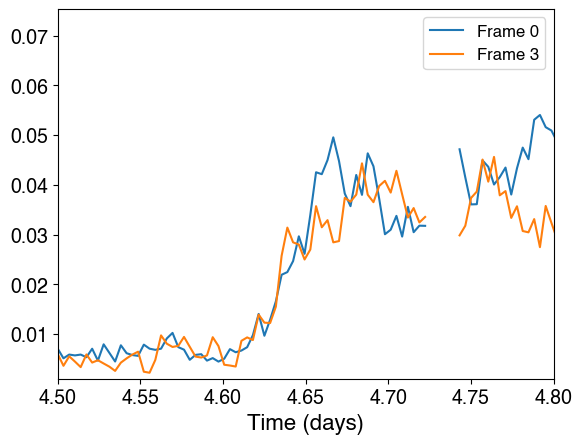

In [771]:
dfFiveMinute.groupby('Time (days)').mean()['Frame 0'].plot(label='Frame 0')
dfFiveMinute.groupby('Time (days)').mean()['Frame 3'].plot(label='Frame 3')
plt.axis(xmin=4.5,xmax=4.8,ymin=1e-3) # zoomed in to transition
#plt.axis(xmin=0,xmax=8,ymin=1e-4)     # zoomed out
plt.legend()
#plt.yscale('log')

## make animation showing trajectories of all first-festoon events in this time window

In [786]:
def history_trajectory(dfTraj,beeid,start_time,delta_t):
    """
    Return the trajectory of a given bee leading up to an event time, delta_t minutes into the past.

    delta_t:    In minutes.
    """
    
    min_time_framenum = datetime_to_framenum( start_time - dt.timedelta(minutes=delta_t) )
    max_time_framenum = datetime_to_framenum( start_time )

    dfTraj_bee = dfTraj[dfTraj['uid']==beeid]
    return dfTraj_bee[ (dfTraj_bee['framenum'] < max_time_framenum) & (dfTraj_bee['framenum'] > min_time_framenum) ]

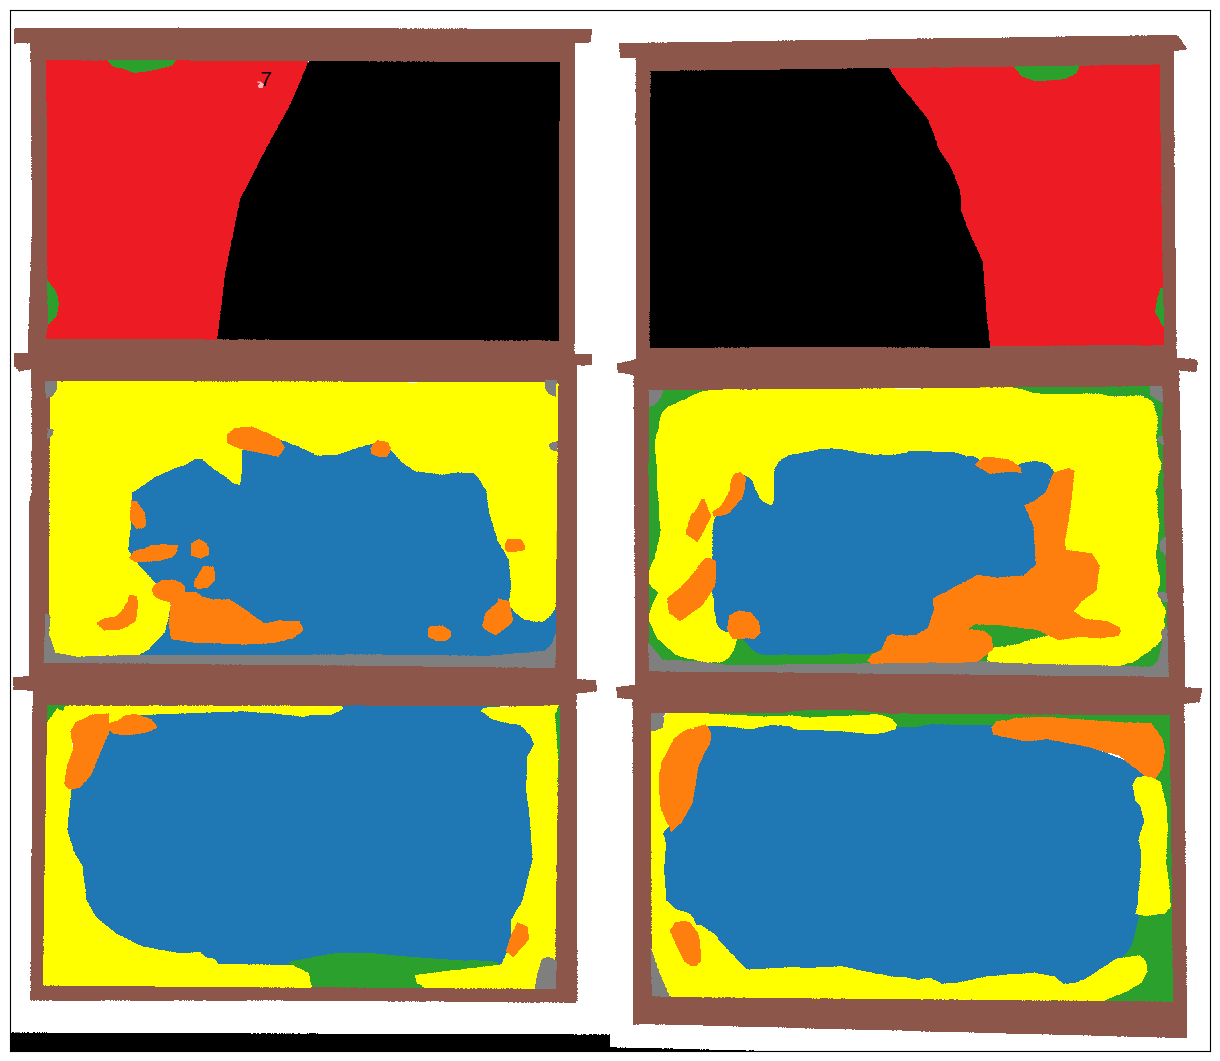

In [820]:
ax = plot_history(dfTraj_cut,7,df_first_festoon_bouts_windowed.loc[7]['Bout start'],2,color='white',show_id=True)

In [832]:
# make animated gif consistng of trajectories before first-festoon events
show_comb = False #True
show_frame = True #False
daynum = int(np.floor(minTimeDays))
make_animation = False #True

def plot_func(beeid,delta_t=delta_t,ax=[]):
    bout_start = df_first_festoon_bouts_windowed.loc[beeid]['Bout start']
    return plot_history(dfTraj_windowed,
                        beeid,
                        bout_start,
                        delta_t, 
                        show_comb=show_comb,
                        show_frame=show_frame,
                        ax=ax,
                        show_id=True,
                        maxxydiff=1e10)

beeIDs = list( df_first_festoon_bouts_windowed.index )

if make_animation:
    gifsicle.gifsiclePlot(plot_func,
                              beeIDs,
                              '240419_bee_histories_before_first_festoon_day{}_{}_to_{}.gif'.format(daynum,minTime.time(),maxTime.time()),
                              delay=1,
                              annotateList=["bee ID: {}".format(beeID) for beeID in beeIDs])
    plt.close('all')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

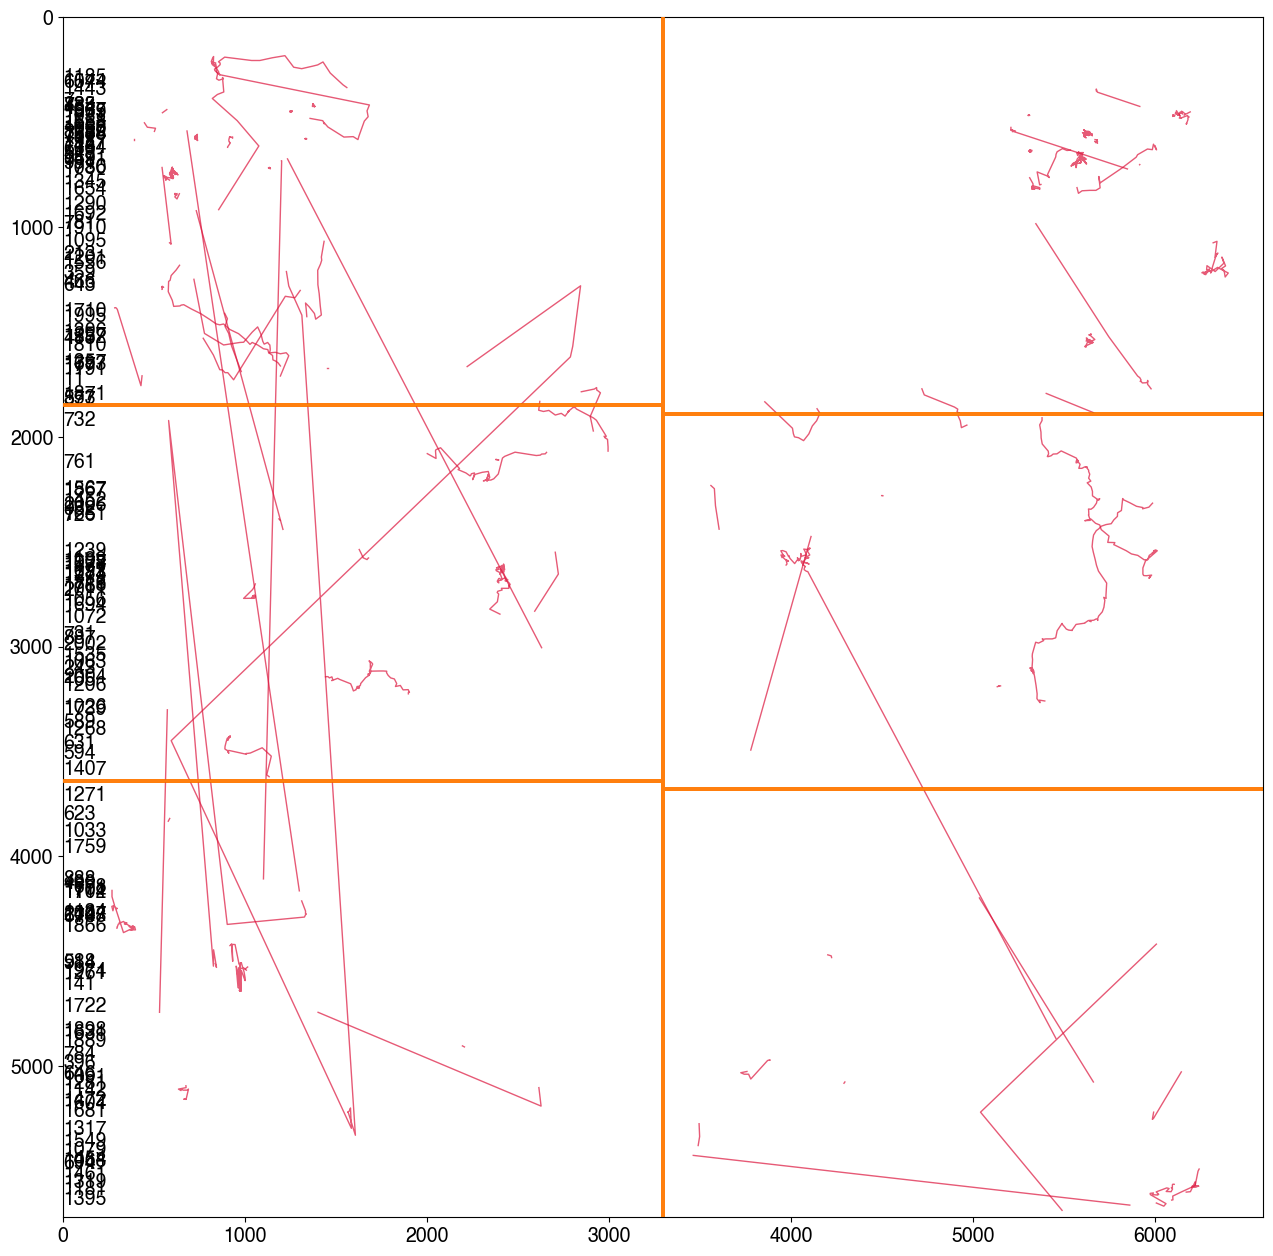

In [864]:
# plot all first-festoon histories on same plot
ax = []
for beeID in beeIDs:
    #print(beeID)
    ax = plot_func(beeID,ax=ax)

In [861]:
t = history_trajectory(dfTraj_windowed,490,df_first_festoon_bouts_windowed.loc[490]['Bout start'],delta_t)

In [865]:
def add_speed_data(t,pixels_per_cm=80,frames_per_second=frames_per_second):
    """
    Adds speed data to a given trajectory dataFrame.
    """
    t['delta x'] = np.concatenate([[np.nan],np.diff(t['x'])])
    t['delta y'] = np.concatenate([[np.nan],np.diff(t['y'])])
    t['delta framenum'] = np.concatenate([[np.nan],np.diff(t['framenum'])])
    t['speed (cm/s)'] = np.linalg.norm([t['delta x'],t['delta y']],axis=0)/pixels_per_cm / (t['delta framenum']/frames_per_second)